# SCP - Accommodation Calculations for POS Tags
## TTest for statistical Accuracy

This notebook was used to generate results for accommodtion calculations and contains statistical tests verifying the validity of experimental results. 

In [1]:
import nltk
import pandas as pd
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import Counter
import BigramCode as bi

import NRCHash as nrc

In [2]:
import SCP_Code as scp

In [1]:
# Translate csv to Dataframe BEST SO FAR
tweetData = pd.read_csv('pairs_edit_utf_noSquig.csv', sep='~',)
tweetData.head()

In [4]:
## To run when parsing pos tag results
dataA = pd.read_csv('A_Tweets_Tagged.txt', sep='\t', header=None)
dataA.columns = ['Tokens', 'Tags', 'Conf','Raw Tweet']

dataB = pd.read_csv('B_Tweets_Tagged.txt', sep='\t', header=None)
dataB.columns = ['Tokens', 'Tags', 'Conf','Raw Tweet']

### Combine A and B Tags with Username-replier pairs

In [ ]:
combo = pd.DataFrame()
combo = dataA.copy()
combo = combo.drop(['Tokens'],axis = 1)
combo = combo.drop(['Conf'],axis=1)
combo = combo.drop(['Raw Tweet'],axis=1)
combo.head()

In [ ]:
combo['Tags_B']= dataB['Tags']
combo.head()

In [ ]:
pairs = []
for i in range(len(tweetData)):
    pairs.append(tuple([tweetData.a_username[i],tweetData.b_username[i]]))

In [101]:
count = Counter(pairs).most_common(1)
count

In [3]:
combo['Pairs'] = pairs
print(len(combo))
combo.head()

In [9]:
combo.drop(326167,inplace=True)
len(combo)

326167

In [4]:
count = Counter(combo['Pairs'])
count

In [11]:
len(count) # number of unique t/r pairs

69148

In [12]:
for k in list(count):
    if count[k] < 10: # Delete tweet-reply username pairs with fewer than 10 messages
        del count[k]
len(count)

7392

In [5]:
# Get list of only username pairs that have 10 or more tweet-reply messages between that unique user pair
countList = []
for item in list(count):
    countList.append(item)
countList[0:5]

In [6]:
# Create dataframe for user-reply pairs contained in the >10 countlist
comboreal = combo[combo['Pairs'].isin(countList)]
comboreal = comboreal.reset_index()
comboreal[0:20]

In [257]:
print(len(combo),len(comboreal)) # Length of entire dataset, length of accommodation-appropriate dataset

326167 174858


In [15]:
comboreal.fillna({'Tags':'B'}, inplace=True)
comboreal.fillna({'Tags_B':'B'}, inplace=True)

In [17]:
shared = nrc.getSharedMarkers(comboreal['Tags'],comboreal['Tags_B'])
print(len(shared),shared[0:5])

174858 [['N', ',', 'O', 'V', 'R', 'A', 'E'], ['N', 'R', 'V', ','], ['A', 'P', 'V', 'O', 'R'], ['V', 'R', 'D', 'N', 'P', ',', 'A', '^'], ['V', 'N', ',', 'D', 'P']]


In [21]:
markerset = ['P','D','O','&','N','S','^','Z','L','M','V','A','R','!','T','X','Y','#','U','E','$',',','G']
# No 'D' in shared at all 

In [22]:
# This function iterates through the dataframe to generate a list of shared tweets between a user pair. It 
# Creates three lists: the tags of each user pair and the shared markers between them. 
def UNIterateforSCPPairScore(dataframe,userPair,shared):
    tempA = []
    tempB = []
    tempsh = []
    for num in range(len(dataframe)):
        if dataframe['Pairs'][num] == userPair: # check to see if the row matches UN pairs to be calc.
            tempA.append(dataframe['Tags'][num])
            tempB.append(dataframe['Tags_B'][num])
            tempsh.append(shared[num])
    return([tempA,tempB,tempsh])


# Call on below functions to get accommodation score for a set of markers, the USername tweet tags, 
# and the shared tags between them (generated from UNIterateforSCPPairScore)
def calculateAccom(markerset,UNTweetTagsA,UNTweetTagsB,SharedABTags):
    minDict= {}
    for marker in markerset:
        minDict[marker] = getMin(marker,UNTweetTagsB) # BAvg
        marker2 = marker+'2' # Generate a readable marker to store the subtrahend
        minDict[marker2] = getSub(marker,UNTweetTagsA,SharedABTags) # marker2 = B|A
    return minDict


# Stylistic Accommodation Calculation functions:
# for each ordered user pair and dimension C, fraction of b's replies to a in which b's tweet exhibits C
def getMin(marker,listB): #B Avg
    numerator = scp.countMarkers(marker,listB)#b's replies to A in which marker is present
    denom = len(listB) # number of b's replies to A
    if denom == 0:
        return np.nan
    else:
        return (numerator/denom)

def getSub(marker,listA,shared): #B given A
    numerator = scp.countMarkers(marker,shared) #b and a show marker
    denom = scp.countMarkers(marker,listA) # a shows marker
    if denom == 0:
        return np.nan
    else:
        return(numerator/denom)

def getAcc(marker,listA,listB,shared):
    minuend = getMin(marker,listB)
    subtrahend = getSub(marker,listA,shared)
    if subtrahend == 0:
        return np.nan
    else:
        return([minuend,subtrahend])

In [32]:
# Function to put together all of the above accommodation functions for pos tags. 
def fullForm(usernameList,dataframe,markers,shared):
    minDict = {}
    for userPair in usernameList:
        temp = UNIterateforSCPPairScore(dataframe,userPair,shared)# temp consists of [A_lst,B_lst,Shared]
        minDict[userPair] = calculateAccom(markers,temp[0],temp[1],temp[2])
    return minDict

In [7]:
# Generate scp values for pos tags
allScorestemp = fullForm(countList,comboreal,markerset,shared)
allScorestemp

In [34]:
#Write df to CSV
allScoresDF = pd.DataFrame.from_dict(allScorestemp,orient='index')
allScoresDF.to_csv('SCP_Acc_Scores.csv',sep = '~')

In [8]:
allScoresDF.head()# POS tags

In [60]:
# Acc(C) = mean of the set of b|a estimations - mean of set of b estimations
#marker2 - marker = AccC
x = means.to_frame()#.reset_index()
x.columns=['Score']
x=x.reset_index()

In [61]:
x

,index,Score
0,P,0.677392
1,P2,0.700926
2,D,0.617075
3,D2,0.640049
4,O,0.673383
5,O2,0.691538
6,&,0.287185
7,&2,0.313079
8,N,0.793063
9,N2,0.805042


In [62]:
# Calculate average difference between minuend and subtrahend estimations 
scoreDict = {}
for i in range(len(x)):
    if i%2 == 1:
        scoreDict[x['index'][i-1]]= (x['Score'][i] - x['Score'][i-1])
scoreDict

{'P': 0.023533835801574754,
 'D': 0.022973398348041907,
 'O': 0.018154543978039173,
 '&': 0.02589427511709802,
 'N': 0.011979209702744575,
 'S': 0.009763045128993049,
 '^': 0.07342848542747538,
 'Z': 0.031816472570680106,
 'L': 0.03118132665001644,
 'M': nan,
 'V': 0.010826151859278155,
 'A': 0.027884770462709096,
 'R': 0.02329831414714345,
 '!': 0.01891185208403362,
 'T': 0.030141022710828427,
 'X': 0.01856644882105761,
 'Y': -0.0003910700511995151,
 '#': 0.1634223060067114,
 'U': 0.029806270414191326,
 'E': 0.12056034098249954,
 '$': 0.08205123714363508,
 ',': 0.0049340563787736436,
 'G': 0.03054462148185144}

In [102]:
scoreDictDF = pd.DataFrame.from_dict(scoreDict, orient='index')
scoreDictDF.columns = ['Accommodation']
scoreDictDF.head()

,Accommodation
P,0.023534
D,0.022973
O,0.018155
&,0.025894
N,0.011979


In [86]:
# Generate dictionaries of minuend and subtrahend scores from scoreDict
ScoreListBAvg = {}
ScoreListBGivA = {}
for i in range(len(x)):
    if i%2 == 0:
        ScoreListBAvg[x['index'][i]] = x['Score'][i]
    elif i%2 == 1:
        ScoreListBGivA[x['index'][i-1]] = x['Score'][i]
len(ScoreListBGivA)

23

In [89]:
ScoreListBGivA = pd.DataFrame.from_dict(ScoreListBGivA,orient='index')
ScoreListBAvg = pd.DataFrame.from_dict(ScoreListBAvg,orient='index')

In [91]:
ScoreListBAvg.columns = ['B']
ScoreListBGivA.columns = ['B|A']
ScoreListBAvg.head()

,B
P,0.677392
D,0.617075
O,0.673383
&,0.287185
N,0.793063


In [103]:
scoreDictDF['BAvg'] = ScoreListBAvg['B']
scoreDictDF['BGivenA'] = ScoreListBGivA['B|A']
scoreDictDF.head()

,Accommodation,BAvg,BGivenA
P,0.023534,0.677392,0.700926
D,0.022973,0.617075,0.640049
O,0.018155,0.673383,0.691538
&,0.025894,0.287185,0.313079
N,0.011979,0.793063,0.805042


In [106]:
scoreToPlotBar = scoreDictDF.copy()
scoreToPlotBar = scoreToPlotBar.drop(['Accommodation'], axis = 1)
scoreToPlotBar

,BAvg,BGivenA
P,0.677392,0.700926
D,0.617075,0.640049
O,0.673383,0.691538
&,0.287185,0.313079
N,0.793063,0.805042
S,0.005529,0.015292
^,0.283161,0.356590
Z,0.011963,0.043780
L,0.286048,0.317229
M,0.000000,NaN


In [93]:
# Create Visualizations and save tables
with open ('SCP_POS_Accomodation.tex','w') as tf:
    tf.write(scoreDictDF.to_latex())

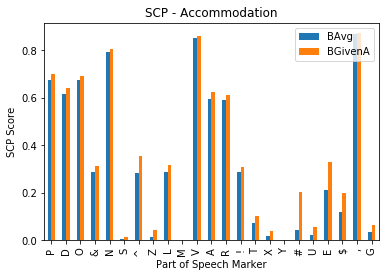

In [145]:
# Visualize dataframe to horizontal bar chart
plot1 = scoreToPlotBar.plot(kind = 'bar')#,figsize = (15,7))#, stacked = True)#,figsize = (20,10))
                    
#plot1.tick_params(labelbottom=False, bottom=False,which='both')
plt.ylabel('SCP Score')
plt.xlabel('Part of Speech Marker')
plt.title('SCP - Accommodation')
plt.savefig('Accommodation_AllVals_POSTags_2')

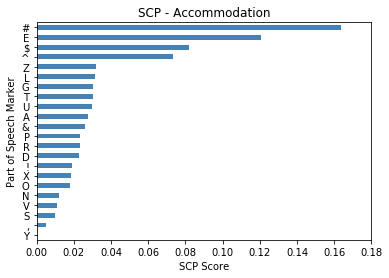

In [150]:
# Visualize just accommodation score
# Visualize dataframe to horizontal bar chart
plot1 = scoreDictDF['Accommodation'].sort_values().plot(kind = 'barh',color='steelblue')#,figsize = (15,10))
                    
#plot1.tick_params(labelbottom=False, bottom=False,which='both')
plt.xlim(0,0.18)
plt.xlabel('SCP Score')
plt.ylabel('Part of Speech Marker')
plt.title('SCP - Accommodation')
plt.savefig('Accommodation_Diff_Score_POSTags_2')

In [129]:
scoreDictDF.drop('M',inplace=True)
scoreDictDF # mean scores

,Accommodation,BAvg,BGivenA
P,0.023534,0.677392,0.700926
D,0.022973,0.617075,0.640049
O,0.018155,0.673383,0.691538
&,0.025894,0.287185,0.313079
N,0.011979,0.793063,0.805042
S,0.009763,0.005529,0.015292
^,0.073428,0.283161,0.356590
Z,0.031816,0.011963,0.043780
L,0.031181,0.286048,0.317229
V,0.010826,0.850454,0.861280


## Paired T Test for pos tags:

In [119]:
from scipy import stats

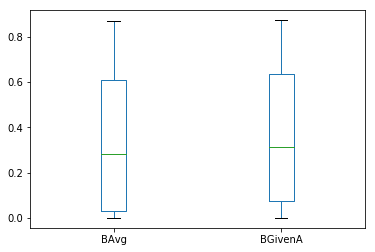

In [121]:
# null hypothesis that these probabilities are the same - mean difference is 0
# alternate hypothesis that the mean difference between samples is not 0. Checks for outliers. 
scoreDictDF[['BAvg','BGivenA']].plot(kind='box')
plt.savefig('boxplot_outliers_POStags.png')

In [10]:
TTestDict = {}
for marker in markerset:
    TTestDict[marker] = (stats.ttest_rel(allScoresDF[marker],allScoresDF[marker+'2']))

In [141]:
TTestDF = pd.DataFrame.from_dict(TTestDict,orient='index')
TTestDF

,statistic,pvalue
P,-21.472420,2.897489e-99
D,-18.747388,1.194943e-76
O,-17.545885,1.477255e-67
&,-6.631804,3.549812e-11
N,-17.483887,4.204588e-67
S,8.318579,1.050567e-16
^,-26.830067,2.139447e-151
Z,3.471663,5.202026e-04
L,-7.196751,6.772679e-13
M,NaN,NaN


In [142]:
TTestDF =TTestDF.drop('statistic',axis=1)
TTestDF.head()

,pvalue
P,2.897489e-99
D,1.194943e-76
O,1.477255e-67
&,3.549812e-11
N,4.204588e-67


In [143]:
with open ('Accom_TTest.tex','w') as tf:
    tf.write(TTestDF.to_latex())